In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import accuracy_score

import random

In [2]:
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


# data processing

In [3]:
# same as sklearn 
df = pd.read_csv("data/allHorizonData_cut.csv")

# features = ['gameLength', 'uc', 'r1', 'r2', 'r3', 'r4', 'c1', 'c2', 'c3', 'c4', 'rt1', 'rt2', 'rt3', 'rt4']
features = ['gameLength', 'uc', 'r1', 'c1', 'rt1', 'r2', 'c2', 'rt2', 'r3', 'c3', 'rt3', 'r4', 'c4', 'rt4']
target = 'c5'

X = df[features]
y = df[target]
y = y-1 # binary CE only takes in 0, 1

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# split based on original data frame
h1_mask = X_test['gameLength'] == 5
h6_mask = X_test['gameLength'] == 10

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

print("--- Feature Data (X) ---")
print(X.head())
print("\n--- Target Data (y) ---")
print(y.head())

--- Feature Data (X) ---
   gameLength  uc  r1  c1       rt1  r2  c2       rt2  r3  c3       rt3  r4  \
0           5   3  66   2  1.849054  80   2  1.771619  29   1  0.562676  75   
1          10   3  69   2  0.967068  50   2  0.495166  51   1  0.506639  64   
2          10   2  31   2  0.862793  43   1  0.490816  26   2  0.924838  36   
3          10   2  65   1  6.272626  77   2  1.204784  52   2  0.795462  73   
4          10   2  70   2  0.614185  19   1  0.364167  43   2  0.306713  41   

   c4       rt4  
0   2  0.578808  
1   2  0.460037  
2   1  0.951034  
3   1  0.457327  
4   1  0.372321  

--- Target Data (y) ---
0    1
1    0
2    0
3    0
4    1
Name: c5, dtype: int64


convert to tensor for pytorch

In [4]:
print(type(X_train))
print(type(y_train))

<class 'numpy.ndarray'>
<class 'pandas.core.series.Series'>


In [5]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32) # sklearn output float64, doesn't work with torch
X_test_tensor = torch.tensor(X_test, dtype=torch.float32) 

y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long) # pandas series to tensor
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [6]:
train_loader = DataLoader(TensorDataset(X_train_tensor, y_train_tensor), batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(X_test_tensor, y_test_tensor), batch_size=32, shuffle=False)

In [7]:
# get the scaled tensor for h1 h6
# convert pandas series -> numpy array -> torch BoolTensor
h1_mask_bool = torch.tensor(h1_mask, dtype=torch.bool)
h6_mask_bool = torch.tensor(h6_mask, dtype=torch.bool)

X_test_h1 = X_test_tensor[h1_mask_bool]
X_test_h6 = X_test_tensor[h6_mask_bool]

y_test_h1 = y_test_tensor[h1_mask_bool]
y_test_h6 = y_test_tensor[h6_mask_bool]

test_loader_h1 = DataLoader(TensorDataset(X_test_h1, y_test_h1), batch_size=32, shuffle=False)
test_loader_h6 = DataLoader(TensorDataset(X_test_h6, y_test_h6), batch_size=32, shuffle=False)

# Model

In [8]:
class MLP(nn.Module):
    def __init__(self, input_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 32)
        self.fc2 = nn.Linear(32, 16)
        self.output = nn.Linear(16, output_size)

        self.relu = nn.ReLU()
        self.gelu = nn.GELU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.gelu(x)
        x = self.output(x)
        return x

# train / eval

In [9]:
def train(model, train_loader, criterion, optimizer, device, epoch): 
    model.train()
    train_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_loader):
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        preds = model(inputs)
        loss = criterion(preds, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    avg_loss = train_loss / len(train_loader)
    return avg_loss


def test(model, test_loader, device):
    model.eval()
    correct = 0
    
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            preds = model(inputs)
            preds = preds.argmax(dim=1)
            correct += (preds == labels).sum().item()
    accuracy = correct / len(test_loader.dataset)
    return accuracy

# running experiment

In [10]:
num_features = len(features)
num_classes = 2

model = MLP(num_features, num_classes).to(device)
print(model)

MLP(
  (fc1): Linear(in_features=14, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=16, bias=True)
  (output): Linear(in_features=16, out_features=2, bias=True)
  (relu): ReLU()
  (gelu): GELU(approximate='none')
  (sigmoid): Sigmoid()
)


In [11]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [12]:
epochs = 20
loss_prog = []
acc_prog = []
acc_h1_prog = []
acc_h6_prog = []

for epoch in range(epochs):
    loss = train(model, train_loader, criterion, optimizer, device, epoch)
    acc = test(model, test_loader, device)
    acc_h1 = test(model, test_loader_h1, device)
    acc_h6 = test(model, test_loader_h6, device)
    print(f"Epoch {epoch+1}: Loss: {loss:.4f} | overall: {acc:.4f} | H1 {acc_h1:.4f} | H6 {acc_h6:.4f}")

    loss_prog.append(loss)
    acc_prog.append(acc)
    acc_h1_prog.append(acc_h1)
    acc_h6_prog.append(acc_h6)

Epoch 1: Loss: 0.6018 | overall: 0.7836 | H1 0.8192 | H6 0.7474
Epoch 2: Loss: 0.5000 | overall: 0.7823 | H1 0.8249 | H6 0.7390
Epoch 3: Loss: 0.4888 | overall: 0.7964 | H1 0.8347 | H6 0.7574
Epoch 4: Loss: 0.4830 | overall: 0.7927 | H1 0.8347 | H6 0.7500
Epoch 5: Loss: 0.4779 | overall: 0.7979 | H1 0.8425 | H6 0.7526
Epoch 6: Loss: 0.4760 | overall: 0.8000 | H1 0.8430 | H6 0.7563
Epoch 7: Loss: 0.4739 | overall: 0.7961 | H1 0.8399 | H6 0.7516
Epoch 8: Loss: 0.4714 | overall: 0.7974 | H1 0.8430 | H6 0.7511
Epoch 9: Loss: 0.4698 | overall: 0.7940 | H1 0.8373 | H6 0.7500
Epoch 10: Loss: 0.4687 | overall: 0.8029 | H1 0.8466 | H6 0.7584
Epoch 11: Loss: 0.4678 | overall: 0.7979 | H1 0.8404 | H6 0.7547
Epoch 12: Loss: 0.4673 | overall: 0.7932 | H1 0.8332 | H6 0.7526
Epoch 13: Loss: 0.4657 | overall: 0.7995 | H1 0.8461 | H6 0.7521
Epoch 14: Loss: 0.4650 | overall: 0.8055 | H1 0.8512 | H6 0.7589
Epoch 15: Loss: 0.4634 | overall: 0.7971 | H1 0.8435 | H6 0.7500
Epoch 16: Loss: 0.4627 | overall: 

In [13]:
import matplotlib.pyplot as plt

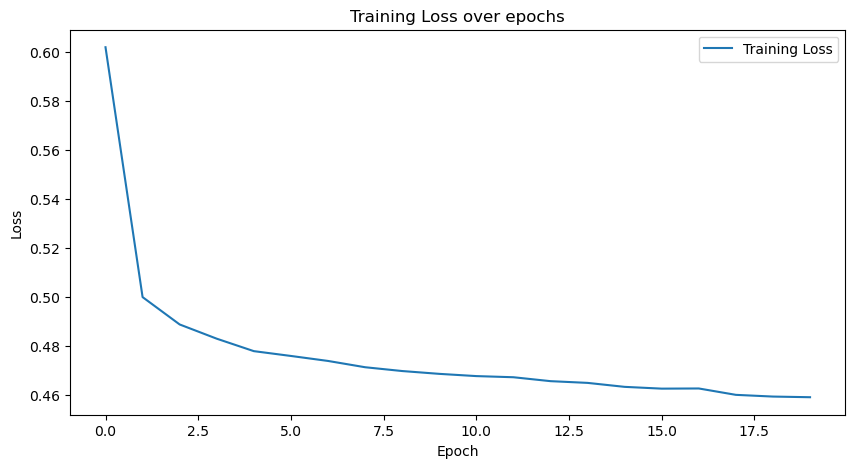

In [14]:
# plot training and testing loss
plt.figure(figsize=(10, 5))
plt.plot(range(epochs), loss_prog, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss over epochs')
plt.legend()
plt.show()

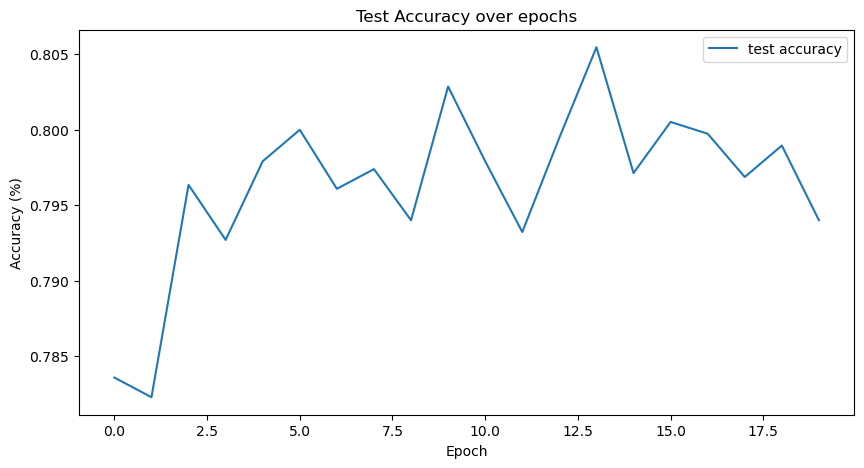

In [15]:
# plot testing accuracy
def plot_accuracy(accuracy_progress_list):
    plt.figure(figsize=(10, 5))
    for label, acc in accuracy_progress_list:
        plt.plot(range(epochs), acc, label=label)
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.title('Test Accuracy over epochs')
    plt.legend()
    plt.show()

plot_accuracy([('test accuracy', acc_prog)])

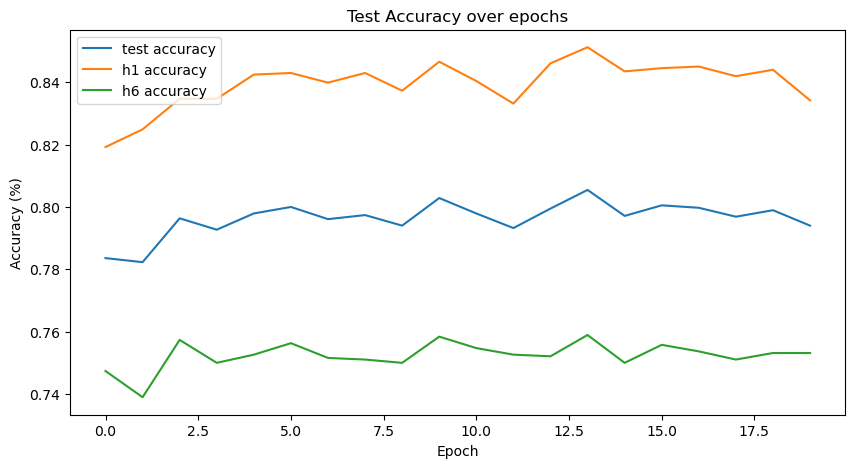

In [16]:
plot_accuracy([('test accuracy', acc_prog), ('h1 accuracy', acc_h1_prog), ('h6 accuracy', acc_h6_prog)])